In [1]:
import os
import sys
import time
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

folder = os.path.dirname('../')
sys.path.append(folder)

from codebase.utils.log import Log
from codebase.datasets import TextDataset, DataPreprocess
from codebase.utils.prepare import Preparation
from codebase.condGAN import condGAN
%matplotlib inline

In [2]:
# Preparing environment
prep = Preparation()
cfg = prep.set_config('cfg/eval_1_4_bird.yml')
cfg.MANUAL_SEED = 41
prep.set_random_seed()
output_dir = prep.set_output_dir()
prep.set_cuda()
prep.show_config()

manual_seed = 41
{'B_VALIDATION': False,
 'CONFIG_NAME': 'Eval1',
 'CUDA': False,
 'DATASET_NAME': 'birds',
 'DATA_DIR': '../data/birds',
 'GAN': {'B_ATTENTION': True,
         'B_DCGAN': False,
         'CONDITION_DIM': 100,
         'DF_DIM': 64,
         'GF_DIM': 32,
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': -1,
 'MANUAL_SEED': 41,
 'RNN_TYPE': 'LSTM',
 'SAVE_DIR': '../results',
 'TEXT': {'CAPTIONS_PER_IMAGE': 10,
          'EMBEDDING_DIM': 256,
          'RNN_LAYERS': 1,
          'WORDS_NUM': 25},
 'TRAIN': {'BATCH_SIZE': 100,
           'B_NET_D': False,
           'DISCRIMINATOR_LR': 0.0002,
           'ENCODER_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_D': [],
           'NET_E': '',
           'NET_E_IMG': '',
           'NET_E_TEXT': '../DAMSMencoders/birds/text_encoder200.pth',
           'NET_G': '../models/birds/attn1_netG_epoch_300.pth',
           'RNN_GRAD_CLIP': 0.25,
           

In [3]:
# Init log
log = Log(output_dir)

# Get data loader
dataprep = DataPreprocess(log)
image_transform = dataprep.image_transform()
dataloader, dataset = dataprep.get_dataloader('test', image_transform, True)

# Define models and go to evaluate
model = condGAN(output_dir, dataloader, dataset.n_words, dataset.ixtoword, log)
start_t = time.time()

Transform: 128
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Load filenames from: ../data/birds/train/filenames.pickle (8855)
Load filenames from: ../data/birds/test/filenames.pickle (2933)
Load from:  ../data/birds/captions.pickle
Dataset test: n_words=5450 emb_num=10
CUDA status: False
GPU ID: -1
Init condGAN ... 


In [4]:
# Text
sentences= [
'a small red bird',
'a small orange bird',
'a small blue bird',
'a small yellow bird',    
'a small black bird'
]

In [5]:
# Make captions
data_dic = {}
captions, cap_lens = model.tokenize_sentences(sentences, dataset.wordtoix)
cap_array, cap_lens, sorted_indices = model.process_captions(captions, cap_lens)
data_dic['generated'] = [cap_array, cap_lens, sorted_indices]

# Generate images from pre-extracted embeddings
images = model.generate_images(data_dic)  # generate images for customized captions
end_t = time.time()
log.add('Total time for evaluation: {}'.format(end_t - start_t))

/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Load text encoder from: ../DAMSMencoders/birds/text_encoder200.pth
Number of nets G/D: 2
Load G from: ../models/birds/attn1_netG_epoch_300.pth


/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
../codebase/global_attention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)
/home/aleksey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is de

Total time for evaluation: 13.142837524414062


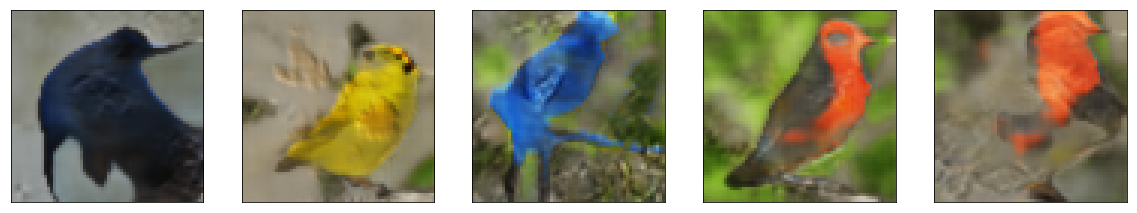

In [6]:
fig = plt.figure(figsize=(20,20))
for i, path in enumerate(images[0][0]):   
    img = Image.open(path)
    ax = fig.add_subplot(4,5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.asarray(img))    

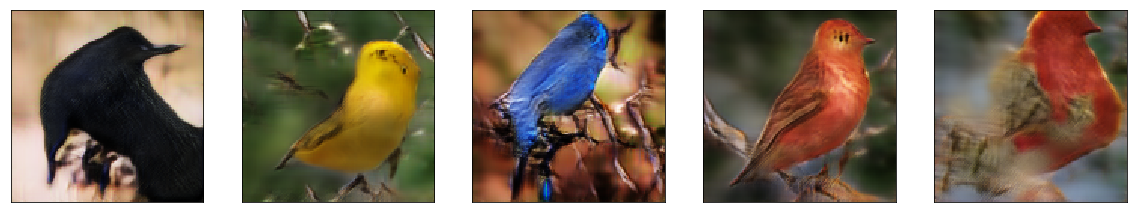

In [7]:
fig = plt.figure(figsize=(20,20))
for i, path in enumerate(images[0][1]):   
    img = Image.open(path)
    ax = fig.add_subplot(4,5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.asarray(img))  